<a href="https://colab.research.google.com/github/eyang9001/NU_Radiology/blob/master/NU_Rad_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
# ! git clone https://github.com/eyang9001/NU_Radiology.git
# ! pip install simpleitk

In [2]:
from sys import platform as sys_pf
# if sys_pf == 'darwin':
#     import matplotlib
#     matplotlib.use("TkAgg")
! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random
import math

folder = 'NU_Radiology/data/'
image_shape = (256,256,176)

tensorflow 1.10.1 has requirement setuptools<=39.1.0, but you'll have setuptools 40.2.0 which is incompatible.
spacy 2.0.16 has requirement numpy>=1.15.0, but you'll have numpy 1.14.3 which is incompatible.
spacy 2.0.16 has requirement regex==2018.01.10, but you'll have regex 2018.11.22 which is incompatible.
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
class mri(object):
    def __init__(self, filename):
        self.conv_file(filename)
        self.ks = np.fft.fftn(img)
        self.ks = np.fft.fftshift(self.ks)
        self.max = np.amax(img)
        self.min = np.amin(img)
        self.ks_vis = np.abs(self.ks)
        self.x, self.y, self.z = self.original.shape
        self.slices = self.x
    
    def conv_file(self, filename):
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NiftiImageIO")
        reader.SetFileName(filename)
        image = reader.Execute()

        # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

        # convert image into np array & perform fft
        img = sitk.GetArrayFromImage(image)
        # Transpose the image so the first axis is Anterior-Posterior
        img = np.transpose(img, (2,1,0))
        self.original = img 
    
    def fft_back(self, kspace):
        # Produce the image given the kspace
        back_fft = np.fft.ifftn(kspace)
        return back_fft
    
    # modifies the whole 3d kspace and then returns a specific slice
    # returns the slice of the modified kspace as well as visual representation
    def mod_kspace_slice(self, trans, rot, slice_num):
        # Rotations are passed in as [yaw, pitch, roll]
        # rotation axes of (1,2) is nodding,(0,2) is shaking, (0,1) is cracking
        mod3d = self.ks.copy()
        mod_v = self.original.copy()
        mod_r = mod3d.real
        mod_i = mod3d.imag
        
        if rot != None:
            # Yaw rotation
            mod_v = ndimage.rotate(mod_v, rot[0], (0,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[0], (0,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[0], (0,2), reshape = False)
            # Pitch rotation
            mod_v = ndimage.rotate(mod_v, rot[1], (1,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[1], (1,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[1], (1,2), reshape = False)
            # Roll rotation
            mod_v = ndimage.rotate(mod_v, rot[2], (0,1), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[2], (0,1), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[2], (0,1), reshape = False)
        if trans != None:
            mod_v = ndimage.shift(mod_v, trans, mode='constant', cval=0)
            mod_r = ndimage.shift(mod_r, trans, mode='constant', cval=0)
            mod_i = ndimage.shift(mod_i, trans, mode='constant', cval=0)
        return mod_r[slice_num] + mod_i[slice_num] *1j, mod_v[slice_num]

    # Translating a specific slice
    # Returns the slice after translation
    def translate(self, space, slice_num, value):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        tran = ndimage.shift(slc,value, mode='constant', cval=0)
        return tran
    
    # Rotating a specific slice
    # Returns the slice after rotation
    def rotate(self, space, slice_num, value, axis=None):
        # If the rotation is in visual space, or k-space
        if space == 'v':
            slc = self.original[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False)
        elif space == 'k':
            slc = self.ks[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False, cval=0)
        return rot
    
    # Displays a slice with an original slice
    def show_slice(self, img, slice_num, space):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        plt.figure(figsize= (20,20))
        plt.subplot(121), plt.imshow(slc, cmap='gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img, cmap='gray')
        plt.title('New'), plt.xticks([]), plt.yticks([])
        
    def create_mod_slices(self, motion):
        modded_k = []
        modded_v = []
        rate = 6  # The number of slices that are skipped for transformations
        
        for i in np.arange(len(self.ks)):
            motion_step = int(i*motion.length/len(self.ks))
            if i % rate == 0:
                trans = [motion.trans_x[motion_step], motion.trans_y[motion_step], motion.trans_z[motion_step]]
                rot = [motion.yaw[motion_step], motion.pitch[motion_step], motion.roll[motion_step]]
                k, v = self.mod_kspace_slice(trans,rot,i)
                modded_k.append(k)
                modded_v.append(v)

                print('Slice #{} out of {} completed'.format(i, len(self.ks)))
            else:
                modded_k.append(self.ks[i])
                modded_v.append(self.original[i])
            # Here, the modded_v is only a visual representation of each slice's transformation
            # It also only returns the modified k-space, so will need to ifft back to vis
        return modded_k, modded_v
    
    def save_to_file(self, data, name):
        # Takes in 3d array and converts to 2d, then saves to file
        output_r=[]
        output_i=[]
        for sublist in data:
            for item in sublist:
                output_r.append(item.real)
                output_i.append(item.imag)
        r_path = name + '_r.txt.gz'
        i_path = name + '_i.txt.gz'
        np.savetxt(r_path, output_r, fmt="%s" ,delimiter=',')
        np.savetxt(i_path, output_i, fmt="%s" ,delimiter=',')

class motion(object):
    def __init__(self, filename):
        self.filename = filename
        self.raw = np.loadtxt(filename)
        self.length = len(self.raw)
        self.yaw = []
        self.pitch=[]
        self.roll=[]
        self.trans_x = []
        self.trans_y = []
        self.trans_z = []
        for i in range(len(self.raw)):
            self.yaw.append(self.raw[i][0]*180/math.pi)
            self.pitch.append(self.raw[i][1]*180/math.pi)
            self.roll.append(self.raw[i][2]*180/math.pi)
            # Still need to figure out the conversion of translations from motion file
            self.trans_x.append(self.raw[i][3]*10)
            self.trans_y.append(self.raw[i][4]*10)
            self.trans_z.append(self.raw[i][5]*10)


In [4]:
for item in os.listdir(folder):
    if item.endswith(".nii"):
        mri1 = mri(folder + item)
        img = mri1.original

FileNotFoundError: [Errno 2] No such file or directory: 'NU_Radiology/data/'

In [ ]:
ks = mri1.ks

# testing to make sure the fft maintains original image
new_3d_ks = ks.copy()
new_3d_vs = mri1.fft_back(new_3d_ks)
mri1.show_slice(np.abs(new_3d_vs[100]), 100, 'v')

In [0]:
mri1=mri(img)
motion1 = motion('NU_Radiology/motion1.dat')
mod_k, mod_v = mri1.create_mod_slices(motion1)

mri1.save_to_file(mod_k, '/content/gdrive/My Drive/mri1_kspace')
mri1.save_to_file(mod_v, '/content/gdrive/My Drive/mri1_vspace')


Slice #0 out of 256 completed
Slice #6 out of 256 completed
Slice #12 out of 256 completed
Slice #18 out of 256 completed
Slice #24 out of 256 completed
Slice #30 out of 256 completed
Slice #36 out of 256 completed
Slice #42 out of 256 completed
Slice #48 out of 256 completed
Slice #54 out of 256 completed
Slice #60 out of 256 completed
Slice #66 out of 256 completed
Slice #72 out of 256 completed
Slice #78 out of 256 completed
Slice #84 out of 256 completed
Slice #90 out of 256 completed
Slice #96 out of 256 completed
Slice #102 out of 256 completed
Slice #108 out of 256 completed
Slice #114 out of 256 completed
Slice #120 out of 256 completed
Slice #126 out of 256 completed
Slice #132 out of 256 completed
Slice #138 out of 256 completed
Slice #144 out of 256 completed
Slice #150 out of 256 completed
Slice #156 out of 256 completed
Slice #162 out of 256 completed
Slice #168 out of 256 completed
Slice #174 out of 256 completed
Slice #180 out of 256 completed
Slice #186 out of 256 compl

In [0]:
mri1.save_to_file(mod_k, '/content/gdrive/My Drive/mri1_kspace')
mri1.save_to_file(mod_v, '/content/gdrive/My Drive/mri1_vspace')

(Text(0.5, 1.0, 'K-space'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

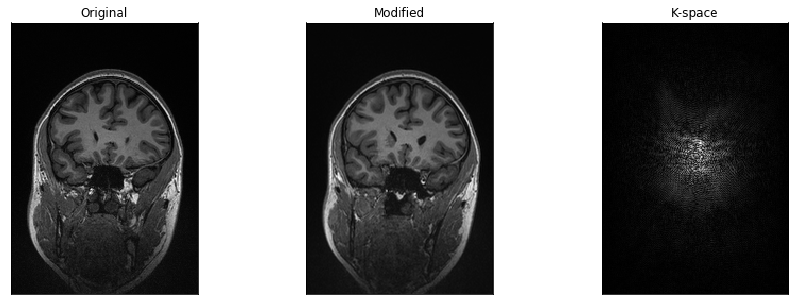

In [0]:
# testing out mod_kspace_slice
# trans = [0,30,0]
# trans = None
# rot = 10
rot = [motion1.yaw[0], motion1.pitch[0], motion1.roll[0]]
trans = [motion1.trans_x[0], motion1.trans_y[0], motion1.trans_z[0]]
slice_num = 100
modded_k, modded_v = mri1.mod_kspace_slice(trans,rot,slice_num)
modded_k_vis = np.abs(modded_k)
plt.figure(figsize= (15,5))
plt.subplot(131), plt.imshow(img[slice_num], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(modded_v, cmap='gray')
plt.title('Modified'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(modded_k_vis, cmap='gray')
plt.title('K-space'), plt.xticks([]), plt.yticks([])

In [0]:
testks = []
for sublist in new_3d_ks:
    for item in sublist:
        testks.append(item.real)

In [0]:
np.savetxt('/content/gdrive/My Drive/testing.txt.gz', testks, fmt="%s" ,delimiter=',')

In [0]:
test2

[[1, 2, 3, 4.3],
 [1, 2, 3, 4],
 [1, 2, 3, 4],
 [1, 2, 3, 4],
 [1, 2, 3, 4],
 [1, 2, 3, 4]]

In [0]:
# Read in kspace file

k_r = np.loadtxt('/content/gdrive/My Drive/mri1_kspace_r.txt.gz', delimiter=",")
k_i = np.loadtxt('/content/gdrive/My Drive/mri1_kspace_i.txt.gz', delimiter=",")
k_r = np.reshape(k_r,image_shape)
k_i = np.reshape(k_i,image_shape)

kspace = k_r + k_i*1j


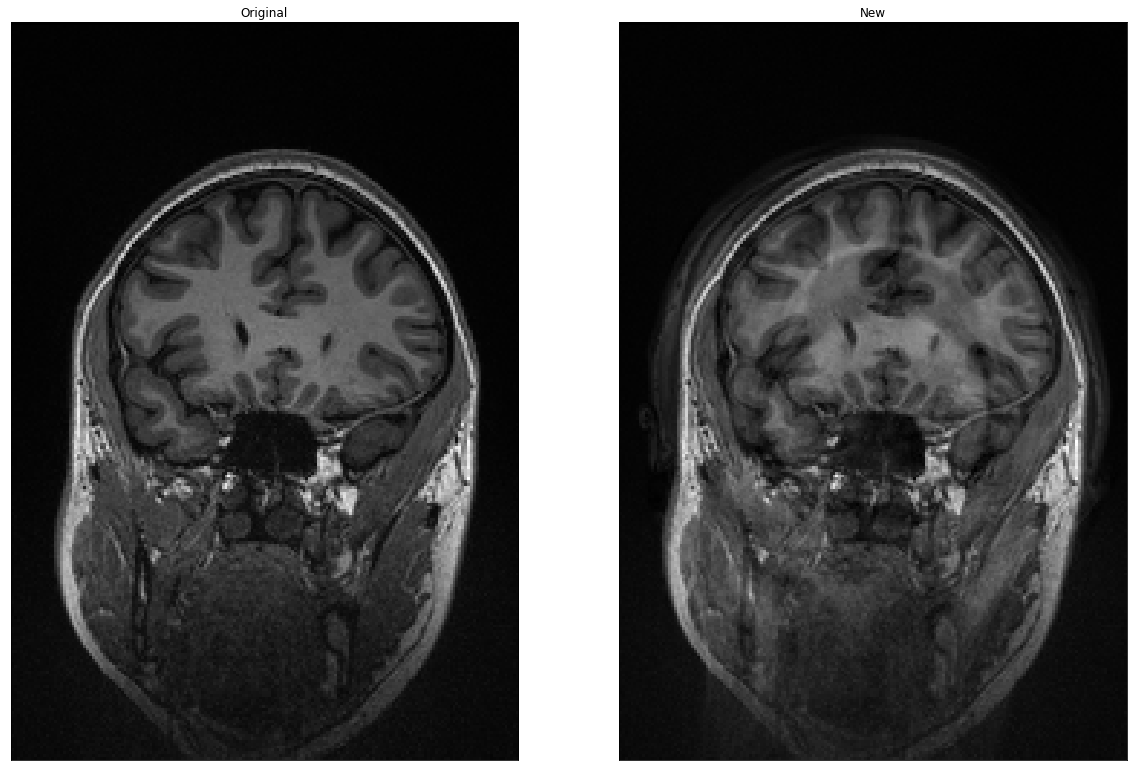

In [0]:
new_vis = mri1.fft_back(kspace)
mri1.show_slice(np.abs(new_vis[100]), 100, 'v')


In [0]:
new_3d_ks.shape

(256, 256, 176)

In [0]:
reshaped = np.reshape(test3,(256,256,176))

In [0]:
reshaped.shape

(256, 256, 176)

In [0]:
reshaped[0]

array([[ -5722.        ,   6622.79242505,   9352.46272179, ...,
         -1977.67124418,   9352.46272179,   6622.79242505],
       [-17238.77152253,   7739.08748378,  10424.84269323, ...,
          1920.58592178, -15273.22641471,   7321.78926585],
       [ -5853.79306748,  15523.24729786, -19657.43110275, ...,
        -15059.0536547 , -11314.54584331,  17065.25426388],
       ...,
       [  -981.10035364,    103.4925449 , -16463.67459952, ...,
          5561.64313615,   2856.24035069,  -7442.0120977 ],
       [ -5853.79306748,  17065.25426388, -11314.54584331, ...,
         -7033.23285686, -19657.43110275,  15523.24729786],
       [-17238.77152253,   7321.78926585, -15273.22641471, ...,
        -10222.57636583,  10424.84269323,   7739.08748378]])

In [0]:
new_3d_ks[0].real

array([[ -5722.        ,   6622.79242505,   9352.46272179, ...,
         -1977.67124418,   9352.46272179,   6622.79242505],
       [-17238.77152253,   7739.08748378,  10424.84269323, ...,
          1920.58592178, -15273.22641471,   7321.78926585],
       [ -5853.79306748,  15523.24729786, -19657.43110275, ...,
        -15059.0536547 , -11314.54584331,  17065.25426388],
       ...,
       [  -981.10035364,    103.4925449 , -16463.67459952, ...,
          5561.64313615,   2856.24035069,  -7442.0120977 ],
       [ -5853.79306748,  17065.25426388, -11314.54584331, ...,
         -7033.23285686, -19657.43110275,  15523.24729786],
       [-17238.77152253,   7321.78926585, -15273.22641471, ...,
        -10222.57636583,  10424.84269323,   7739.08748378]])